# cuML - RAPIDS




## Instalação

In [1]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!pip3 install --upgrade pip # Atualizado em janeiro de 2023, para evitar erros em operações com DataFrames
!python rapidsai-csp-utils/colab/pip-install.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 438, done.
remote: Counting objects: 100% (169/169), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 438 (delta 121), reused 57 (delta 54), pack-reused 269
Receiving objects: 100% (438/438), 118.31 KiB | 953.00 KiB/s, done.
Resolving deltas: 100% (223/223), done.
***********************************************************************
We will now install RAPIDS via pip! 
Please stand by, should be quick...
***********************************************************************

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 955.2/955.2 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 GB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.8/142.8 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
num = 10000
w = 2.0
x = np.random.normal(loc=0, scale=1, size=(num))

In [4]:
x, x.shape

(array([ 0.04154685,  0.25200521, -2.75040538, ...,  1.11447047,
        -2.91421251, -0.40784667]),
 (10000,))

In [5]:
b = 1.0
y = w * x + b

In [6]:
y, y.shape

(array([ 1.0830937 ,  1.50401042, -4.50081076, ...,  3.22894093,
        -4.82842503,  0.18430665]),
 (10000,))

In [7]:
noise = np.random.normal(loc = 0, scale=2, size=(num,))
y_noisy = y + noise

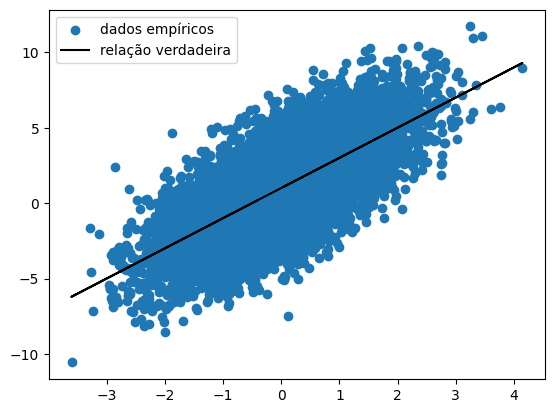

In [8]:
plt.scatter(x, y_noisy, label='dados empíricos')
plt.plot(x, y, color = 'black', label='relação verdadeira')
plt.legend();

## Regressão Linear Simples


A classe LinearRegression implementada no cuML e no Scikit-Learn é baseada em mínimos quadrados ordinários (MQO, tradução de *ordinary least squares - OLS*), que essencialmente são responsáveis por minimizar a distância quadrada entre as observações (pontos azuis) e o relacionamento (linha preta) estimado pela classe.

Isso quer dizer que este é realmente um processo de otimização. O cuML oferece 3 algoritmos para ajustar o modelo linear:
* [Singular Value Decomposition (SVD)](https://www.geeksforgeeks.org/singular-value-decomposition-svd/) - é o mais estável
* [Eigendecomposition (Eig)](https://mathworld.wolfram.com/EigenDecomposition.html) - normalmente é muito mais rápido
* [Coordinate Descente (CD)](https://en.wikipedia.org/wiki/Coordinate_descent) - pode ser mais rápido para dados maiores

### Com o Scikit-Learn


In [9]:
import sklearn
from sklearn.linear_model import LinearRegression
print(sklearn.__version__)

1.2.2


In [10]:
linear_regression = LinearRegression()
type(linear_regression)

sklearn.linear_model._base.LinearRegression

In [11]:
x.shape

(10000,)

In [12]:
np.expand_dims(x, 1).shape

(10000, 1)

In [13]:
linear_regression.fit(np.expand_dims(x, 1), y_noisy)

LinearRegression()

In [14]:
type(x), type(y_noisy)

(numpy.ndarray, numpy.ndarray)

In [15]:
inputs = np.linspace(start=-5, stop=5, num=1000000)

In [16]:
inputs

array([-5.     , -4.99999, -4.99998, ...,  4.99998,  4.99999,  5.     ])

In [17]:
outputs = linear_regression.predict(np.expand_dims(inputs, 1))
outputs

array([-9.08061154, -9.08059136, -9.08057118, ..., 11.1013868 ,
       11.10140699, 11.10142717])

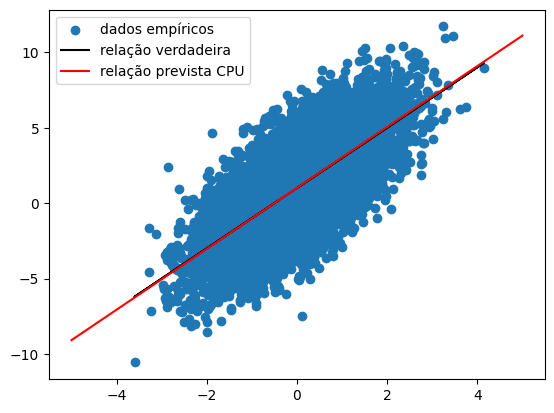

In [18]:
plt.scatter(x, y_noisy, label = 'dados empíricos')
plt.plot(x, y, color='black', label = 'relação verdadeira')
plt.plot(inputs, outputs, color='red', label = 'relação prevista CPU')
plt.legend();

### Com o cuML

In [19]:
import cudf
print(cudf.__version__)

23.12.01


In [20]:
df = cudf.DataFrame({'x': x, 'y': y_noisy})
df.head()

,x,y
0,0.041547,0.846131
1,0.252005,0.516088
2,-2.750405,-3.555637
3,0.290340,2.383669
4,0.435384,2.560157


In [21]:
type(df)

cudf.core.dataframe.DataFrame

In [22]:
import cuml
print(cuml.__version__)
from cuml.linear_model import LinearRegression as LinearRegressionGPU

23.12.00


In [23]:
df['x']

0       0.041547
1       0.252005
2      -2.750405
3       0.290340
4       0.435384
          ...   
9995    0.086491
9996   -0.073171
9997    1.114470
9998   -2.914213
9999   -0.407847
Name: x, Length: 10000, dtype: float64

In [24]:
import cupy as cp
linear_regression_gpu = LinearRegressionGPU()
linear_regression_gpu.fit(cp.expand_dims(cp.array(df['x']), 1), cp.array(y_noisy))

/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:382: UserWarning: Starting from version 23.08, the new 'copy_X' parameter defaults to 'True', ensuring a copy of X is created after passing it to fit(), preventing any changes to the input, but with increased memory usage. This represents a change in behavior from previous versions. With `copy_X=False` a copy might still be created if necessary. Explicitly set 'copy_X' to either True or False to suppress this warning.
  return init_func(self, *args, **filtered_kwargs)
/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:190: UserWarning: Changing solver from 'eig' to 'svd' as eig solver does not support training data with 1 column currently.
  return func(*args, **kwargs)


LinearRegression()

In [25]:
df_cudf = cudf.DataFrame({'inputs': inputs})
df_cudf

,inputs
0,-5.00000
1,-4.99999
2,-4.99998
3,-4.99997
4,-4.99996
...,...
999995,4.99996
999996,4.99997
999997,4.99998
999998,4.99999


In [26]:
type(df_cudf)

cudf.core.dataframe.DataFrame

In [27]:
outputs_gpu = linear_regression_gpu.predict(df_cudf[['inputs']])

In [28]:
type(outputs_gpu)

cupy.ndarray

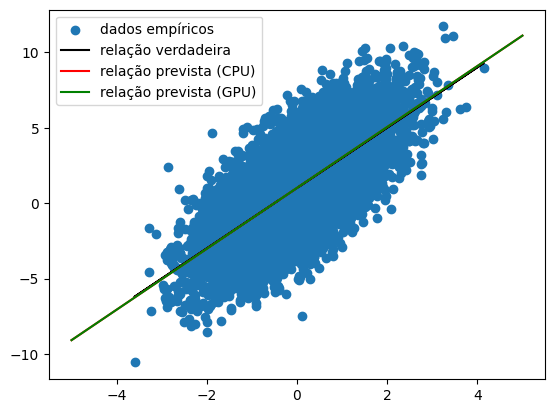

In [29]:
plt.scatter(x, y_noisy, label='dados empíricos')
plt.plot(x, y, color='black', label='relação verdadeira')
plt.plot(inputs, outputs, color='red', label='relação prevista (CPU)')
plt.plot(inputs, outputs_gpu.get(), color='green', label='relação prevista (GPU)')
plt.legend();

## Ridge Regression e Hiperparâmetros


Documentação: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

In [30]:
from sklearn import datasets
diabetes = datasets.load_diabetes()

In [31]:
type(diabetes)

sklearn.utils._bunch.Bunch

In [32]:
diabetes

{'data': array([[ 0.03807591,  0.05068012,  0.06169621, ..., -0.00259226,
          0.01990749, -0.01764613],
        [-0.00188202, -0.04464164, -0.05147406, ..., -0.03949338,
         -0.06833155, -0.09220405],
        [ 0.08529891,  0.05068012,  0.04445121, ..., -0.00259226,
          0.00286131, -0.02593034],
        ...,
        [ 0.04170844,  0.05068012, -0.01590626, ..., -0.01107952,
         -0.04688253,  0.01549073],
        [-0.04547248, -0.04464164,  0.03906215, ...,  0.02655962,
          0.04452873, -0.02593034],
        [-0.04547248, -0.04464164, -0.0730303 , ..., -0.03949338,
         -0.00422151,  0.00306441]]),
 'target': array([151.,  75., 141., 206., 135.,  97., 138.,  63., 110., 310., 101.,
         69., 179., 185., 118., 171., 166., 144.,  97., 168.,  68.,  49.,
         68., 245., 184., 202., 137.,  85., 131., 283., 129.,  59., 341.,
         87.,  65., 102., 265., 276., 252.,  90., 100.,  55.,  61.,  92.,
        259.,  53., 190., 142.,  75., 142., 155., 225.,  59

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(diabetes.data, diabetes.target, test_size=0.2)

In [34]:
X_train.shape, y_train.shape

((353, 10), (353,))

In [35]:
X_test.shape, y_test.shape

((89, 10), (89,))

In [36]:
from cuml import Ridge as cuRidge
from sklearn.linear_model import Ridge as skRidge

In [37]:
type(X_train), type(y_train)

(numpy.ndarray, numpy.ndarray)

In [38]:
alpha = np.array([1.0])
fit_intercept = True

ridge = skRidge(alpha=alpha, fit_intercept=fit_intercept, solver='cholesky')
ridge.fit(X_train, y_train)

Ridge(alpha=array([1.]), solver='cholesky')

> Para o cuML

In [39]:
import cupy as cp
X_train_cp = cp.array(X_train)
y_train_cp = cp.array(y_train)

In [40]:
type(X_train_cp), type(y_train_cp)

(cupy.ndarray, cupy.ndarray)

In [41]:
cuml_ridge = cuRidge(alpha=alpha, fit_intercept=fit_intercept, solver='eig')
cuml_ridge.fit(X_train_cp, y_train_cp)

Ridge()

> Documentação do cuML: https://docs.rapids.ai/api/cuml/stable/api.html#regression-and-classification

## Predição dos valores e avaliação

In [42]:
X_test.shape, y_test.shape

((89, 10), (89,))

In [43]:
type(X_test), type(y_test)

(numpy.ndarray, numpy.ndarray)

In [44]:
print('sklearn: ' + str(ridge.score(X_test, y_test)))

sklearn: 0.4715516844157357


In [45]:
print('cuML: ' + str(cuml_ridge.score(cp.array(X_test), cp.array(y_test))))

cuML: 0.4715516844157358


## Melhorando a acurácia dos modelos com Tuning dos parâmetros

Documentação: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [46]:
from sklearn.model_selection import GridSearchCV

In [47]:
np.logspace(-3, -1, 10)

array([0.001     , 0.0016681 , 0.00278256, 0.00464159, 0.00774264,
       0.0129155 , 0.02154435, 0.03593814, 0.05994843, 0.1       ])

In [48]:
params = {'alpha': np.logspace(-3, -1, 10)}

In [49]:
grid = GridSearchCV(ridge, params, scoring='r2')
grid.fit(X_train, y_train)

GridSearchCV(estimator=Ridge(alpha=array([1.]), solver='cholesky'),
             param_grid={'alpha': array([0.001     , 0.0016681 , 0.00278256, 0.00464159, 0.00774264,
       0.0129155 , 0.02154435, 0.03593814, 0.05994843, 0.1       ])},
             scoring='r2')

In [50]:
grid.best_params_

{'alpha': 0.05994842503189409}

In [51]:
grid.best_score_

0.46842354364318284

In [52]:
grid.best_params_['alpha']

0.05994842503189409

In [53]:
ridge = skRidge(alpha = grid.best_params_['alpha'],
                fit_intercept=fit_intercept,
                solver='cholesky')
ridge.fit(X_train, y_train)

Ridge(alpha=0.05994842503189409, solver='cholesky')

### Otimização de hiperparâmetros para o cuML

In [54]:
cuml_grid = GridSearchCV(cuml_ridge, params, scoring='r2')
cuml_grid.fit(X_train, y_train)
cuml_grid.best_params_, cuml_grid.best_score_

({'alpha': 0.05994842503189409}, 0.46842354364318295)

In [55]:
cuml_ridge = cuRidge(alpha=cuml_grid.best_params_['alpha'], fit_intercept=fit_intercept, solver='eig')
cuml_ridge.fit(X_train_cp, y_train_cp)

Ridge()

# Comparações de desempenho  

- Documentação: https://github.com/rapidsai/cuml/blob/7d86042b8/python/cuml/benchmark/runners.py#L56

In [56]:
from cuml.benchmark.runners import SpeedupComparisonRunner
from cuml.benchmark.algorithms import algorithm_by_name
import pandas as pd

In [57]:
num_reps = 3
dataset_neighborhoods = 'blobs'
dataset_classification = 'classification'
dataset_regression = 'regression'
input_type = 'numpy'

In [58]:
for x in range(14, 17):
  print(x)

14
15
16


In [59]:
2 ** 16

65536

In [60]:
bechmark_results = []
row_sizes = [2**x for x in range(14, 17)]
row_sizes

[16384, 32768, 65536]

In [61]:
features = [32, 256]

In [62]:
def dic_result(algorithm, runner, result):
  result["algo"] = algorithm
  result["dataset_name"] = runner.dataset_name
  result["input_type"] = runner.input_type
  return result

In [63]:
def benchmark(algorithm, runner, verbose=True, run_cpu=True, **kwargs):
  results = runner.run(algorithm_by_name(algorithm), verbose=verbose, run_cpu=run_cpu, **kwargs)
  results = [dic_result(algorithm, runner, result) for result in results]
  bechmark_results.extend(results)

## Regressão Linear

In [64]:
runner = cuml.benchmark.runners.SpeedupComparisonRunner(
    bench_rows = row_sizes,
    bench_dims = features,
    dataset_name=dataset_regression,
    input_type=input_type,
    n_reps=num_reps
)

In [65]:
benchmark("LinearRegression", runner)

Failed to run with 16384 samples, 32 features: Data must be 1-dimensional
Failed to run with 16384 samples, 256 features: Data must be 1-dimensional
Failed to run with 32768 samples, 32 features: Data must be 1-dimensional
Failed to run with 32768 samples, 256 features: Data must be 1-dimensional
Failed to run with 65536 samples, 32 features: Data must be 1-dimensional
Failed to run with 65536 samples, 256 features: Data must be 1-dimensional


In [66]:
bechmark_results

[{'n_samples': 16384,
  'n_features': 32,
  'algo': 'LinearRegression',
  'dataset_name': 'regression',
  'input_type': 'numpy'},
 {'n_samples': 16384,
  'n_features': 256,
  'algo': 'LinearRegression',
  'dataset_name': 'regression',
  'input_type': 'numpy'},
 {'n_samples': 32768,
  'n_features': 32,
  'algo': 'LinearRegression',
  'dataset_name': 'regression',
  'input_type': 'numpy'},
 {'n_samples': 32768,
  'n_features': 256,
  'algo': 'LinearRegression',
  'dataset_name': 'regression',
  'input_type': 'numpy'},
 {'n_samples': 65536,
  'n_features': 32,
  'algo': 'LinearRegression',
  'dataset_name': 'regression',
  'input_type': 'numpy'},
 {'n_samples': 65536,
  'n_features': 256,
  'algo': 'LinearRegression',
  'dataset_name': 'regression',
  'input_type': 'numpy'}]

Para cada benchmark:
 * 'cuml_time' - tempo levado com o cuML (GPU)
 * 'cpu_time' - tempo levado para o scikit-learn (CPU)
 * 'speedup' - a aceleração
 * 'n_samples': número de amostras (será correspondente a um dos row_sizes, que definimos mais acima)
 * 'n_features' - número de features
 * 'algo' - o algoritmo usado
 * 'dataset_name' - dataset usado para o teste

## KMeans

In [67]:
runner = cuml.benchmark.runners.SpeedupComparisonRunner(
    bench_rows=row_sizes,
    bench_dims=features,
    dataset_name=dataset_neighborhoods,
    input_type=input_type,
    n_reps=num_reps
)

benchmark("KMeans", runner)

KMeans (n_samples=16384, n_features=32) [cpu=0.2808222770690918, gpu=0.04703402519226074, speedup=5.970619693321505]
KMeans (n_samples=16384, n_features=256) [cpu=0.5402324199676514, gpu=0.07659602165222168, speedup=7.05300886801321]
KMeans (n_samples=32768, n_features=32) [cpu=0.19695806503295898, gpu=0.05852055549621582, speedup=3.365621931693644]
KMeans (n_samples=32768, n_features=256) [cpu=1.0249450206756592, gpu=0.06552815437316895, speedup=15.641292364787425]
KMeans (n_samples=65536, n_features=32) [cpu=0.26111865043640137, gpu=0.12697410583496094, speedup=2.056471661834733]
KMeans (n_samples=65536, n_features=256) [cpu=2.1649231910705566, gpu=0.1990814208984375, speedup=10.874561680846172]


## Random Forest

In [68]:
runner = cuml.benchmark.runners.SpeedupComparisonRunner(
    bench_rows=row_sizes,
    bench_dims=features,
    dataset_name=dataset_classification,
    input_type=input_type,
    n_reps=num_reps
)

benchmark("RandomForestClassifier", runner)

RandomForestClassifier (n_samples=16384, n_features=32) [cpu=6.831733465194702, gpu=0.2388625144958496, speedup=28.601111729958816]
RandomForestClassifier (n_samples=16384, n_features=256) [cpu=28.090361833572388, gpu=0.3142070770263672, speedup=89.40079294017664]
RandomForestClassifier (n_samples=32768, n_features=32) [cpu=14.991997957229614, gpu=0.27253079414367676, speedup=55.0102897705054]
RandomForestClassifier (n_samples=32768, n_features=256) [cpu=65.47243523597717, gpu=0.4790191650390625, speedup=136.68019990523365]
RandomForestClassifier (n_samples=65536, n_features=32) [cpu=39.02598237991333, gpu=0.40100789070129395, speedup=97.31973680533714]
RandomForestClassifier (n_samples=65536, n_features=256) [cpu=182.16527938842773, gpu=0.7430477142333984, speedup=245.15959863542204]


## Exibindo os gráficos comparativos



In [69]:
df = pd.DataFrame(bechmark_results)
df

,n_samples,n_features,algo,dataset_name,input_type,cuml_time,cpu_time,speedup
0,16384,32,LinearRegression,regression,numpy,NaN,NaN,NaN
1,16384,256,LinearRegression,regression,numpy,NaN,NaN,NaN
2,32768,32,LinearRegression,regression,numpy,NaN,NaN,NaN
3,32768,256,LinearRegression,regression,numpy,NaN,NaN,NaN
4,65536,32,LinearRegression,regression,numpy,NaN,NaN,NaN
5,65536,256,LinearRegression,regression,numpy,NaN,NaN,NaN
6,16384,32,KMeans,blobs,numpy,0.047034,0.280822,5.970620
7,16384,256,KMeans,blobs,numpy,0.076596,0.540232,7.053009
8,32768,32,KMeans,blobs,numpy,0.058521,0.196958,3.365622
9,32768,256,KMeans,blobs,numpy,0.065528,1.024945,15.641292


In [70]:
def plot_speedup(df, algorithm):
  df = df.loc[df.algo == algorithm]
  df = df.pivot(index = "n_samples", columns="n_features", values = "speedup")
  axes = df.plot.bar(title = "Aceleração com %s" % algorithm, rot = 0)

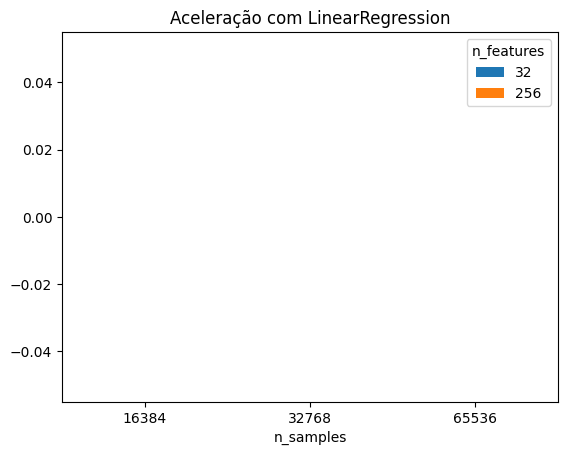

In [71]:
plot_speedup(df, "LinearRegression")

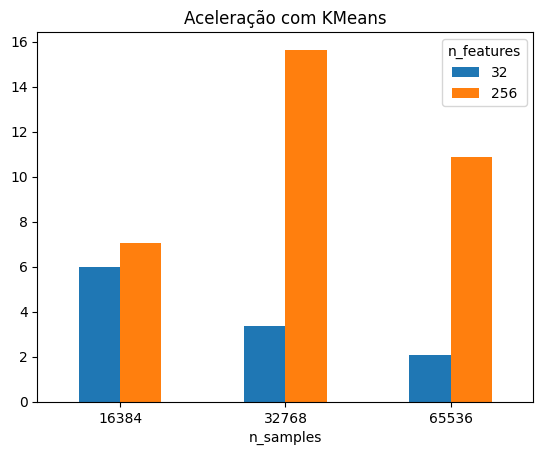

In [72]:
plot_speedup(df, "KMeans")

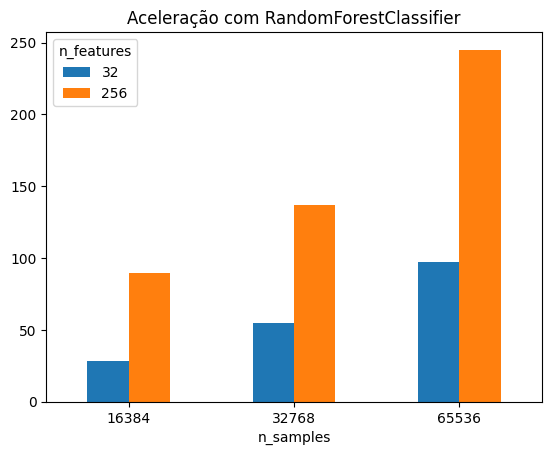

In [73]:
plot_speedup(df, "RandomForestClassifier")

In [74]:
def plot_speedup_multi(df):
  df = df[["algo", "n_samples", "speedup"]].groupby(["algo", "n_samples"]).mean()
  df.plot.bar()

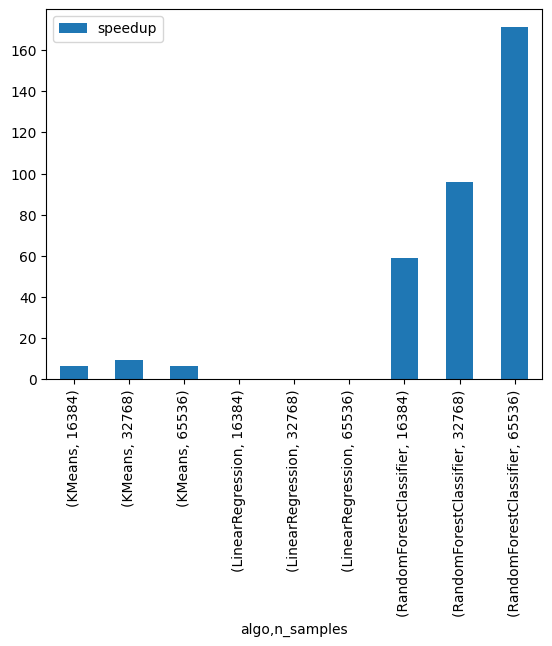

In [75]:
plot_speedup_multi(df)

In [76]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!nvidia-smi

Tue Jan 30 14:29:56 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0              32W /  70W |    301MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--